<a href="https://colab.research.google.com/github/thissop/MAXI-J1535/blob/main/code/notebooks/December-%202021-2022/regressor_pipeline_alpha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes

## Hyperparameters

* SVM Regressor
    * "One of the commonly used kernel functions is radial basis function (RBF)"
    * C: "between 0.1 < c < 100"; I'll do C ⊂ ```{0.1,1,10}``` (default is 1)
        * "If c is small, the penalty for misclassified points is low so a decision boundary with a large margin is chosen at the expense of a greater number of misclassifications"
    * Gamma: how tight the regions are...will use default ```scale```



## IMPORTS

In [477]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale as normalize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, RandomForestClassifier
from sklearn.multioutput import RegressorChain
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib as mpl
import shap

plt.style.use('seaborn-darkgrid')
plt.rcParams['font.family']='serif'
plt.rcParams['figure.dpi']=150

data_csv_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/fixed_merged.csv?token=GHSAT0AAAAAABP54PQODGXCA4HY4XBWECH4YPMUCAA')

## EXECUTE PIPELINE

In [435]:
'''
approaches_dict = {'svm':{'approach':'drop', 'hyperparameters':{'C':[0.1,1,10]}},
                   'rf':{'approach':'flag', 'stat_boundaries':[0.25,5], 'hyperparameters':{'min_samples_leaf':[1, 2, 4],'min_samples_split':[2, 5, 10]}}, 
                   'hgbr':{'approach':'missing', 'stat_boundaries':[0.25,5]}, 'hyperparameters':{'learning_rate':[0,1,1,10], 'min_samples_leaf':[1, 2, 4], 'l2_regularization':[0,1]}}
'''

approaches_dict = {'svm':{'approach':'drop'},
                   'rf':{'approach':'flag'}, 
                   'hgbr':{'approach':'missing'}}

red_chi_boundaries = [0.25, 10]

### Some Shared Methods

In [436]:
def cullBuffers(x, qpo_classes):
    new_x = np.array([], dtype=float).reshape(0,3)
    for x_row, qpo_class in zip(x, qpo_classes): 
        if qpo_class == 0: 
            new_x = np.vstack([new_x, np.zeros(3)])

        elif qpo_class == 1:
            new_x = np.vstack([new_x, [x_row[0], 0, 0]])

        elif qpo_class == 2: 
            new_x = np.vstack([new_x, [x_row[0], x_row[1], 0]])

        elif qpo_class == 3: 
            new_x = np.vstack([new_x, x_row[0:3]])

    return new_x

def knn_predict(k, xtrain, ytrain, xtest, ytest): 
    knn = KNeighborsClassifier(k)
    knn.fit(xtrain, ytrain)
    predictions = knn.predict(xtest)
    acc = accuracy_score(predictions, ytest.flatten())

    return acc, predictions

def normalize_dataframe(dataframe, feature_range): 

    norm_cols = ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
    norm_cols += ['first_par1s','first_par2s','first_norms','second_par1s', 'second_par2s']	
    norm_cols += ['second_norms','third_par1s','third_par2s','third_norms', 'count_rates']

    normalized_df = dataframe.copy() 

    for col_name in norm_cols: 
        arr = np.array(dataframe[col_name])
        arr = normalize(arr, feature_range=feature_range)
        normalized_df[col_name] = arr
    
    return normalized_df #KJLKJFLKSAJLKAJDSLSAJDLK ASDLAJLKJLSADJALKSJDALKSJD SALKDJSLADJ ALSKJD FIX THIS!!!!!!!!!!!!!!! 

def drop_no_qpo(X_test, y_test, knn_qpo_predictions): 
    non_zero_indices = np.where(knn_qpo_predictions!=0)
    return X_test[non_zero_indices], y_test[non_zero_indices]

## Unique Row Identifier Method
* stratified train test split

In [437]:
data_df = normalize_dataframe(data_csv_df.sample(frac=1), (0.0,1))
full_uri_key = np.arange(0, len(data_df.index))

'''
- URI = Unique Row Identifier
    - A way to track rows across different splits, etc. 
- Because pandas series values were getting really annoying
  given how they would carry over across shuffles, etc.  
'''

red_chis = np.array(data_df['red_fit_stats'])

lower_red_chi = 0.1
upper_red_chi = 10

red_chi_kept = np.logical_and(red_chis>=lower_red_chi, 
                              red_chis<=upper_red_chi)

qpo_mask = [np.array(data_df['first_par1s'])!=0][0]

uri_with_qpo = full_uri_key[qpo_mask]
uri_without_qpo = full_uri_key[np.invert(qpo_mask)] 

poor_quality_uri = full_uri_key[np.invert(red_chi_kept)]
good_quality_uri = full_uri_key[red_chi_kept]

# get indices for rows within red chi range with qpos

good_quality_uri_with_qpo = np.intersect1d(good_quality_uri, uri_with_qpo)
gquwq_length = len(good_quality_uri_with_qpo) # Good Quality Uri With Qpo

gquwq_boundary_index = int(0.9*gquwq_length) # e.g. if it's 16, train is [0:16) and test is [16:]

gquwq_train = good_quality_uri_with_qpo[0:gquwq_boundary_index]
gquwq_test = good_quality_uri_with_qpo[gquwq_boundary_index:]

# get indices for rows inside of red chi range without qpos
good_quality_uri_no_qpo = np.intersect1d(good_quality_uri, uri_without_qpo)
gqunq_length = len(good_quality_uri_no_qpo) # Good Quality Uri No Qpo

gqunq_boundary_index = int(0.9*gqunq_length) # e.g. if it's 16, train is [0:16) and test is [16:]

gqunq_train = good_quality_uri_no_qpo[0:gqunq_boundary_index]
gqunq_test = good_quality_uri_no_qpo[gqunq_boundary_index:]

# concat indices for rows inside of red chi range
good_quality_uri_combined_train = np.concatenate((gquwq_train, gqunq_train))
good_quality_uri_combined_test = np.concatenate((gquwq_test, gqunq_test))

# get indices for rows outside red chi range with qpos
poor_quality_uri_with_qpo = np.intersect1d(poor_quality_uri, uri_with_qpo)
pquwq_length = len(poor_quality_uri_with_qpo) # Poor Quality Uri With Qpo

pquwq_boundary_index = int(0.9*pquwq_length) 

pquwq_train = poor_quality_uri_with_qpo[0:pquwq_boundary_index]
pquwq_test = poor_quality_uri_with_qpo[pquwq_boundary_index:]

# get indices for rows outide red chi range without qpos
poor_quality_uri_no_qpo = np.intersect1d(poor_quality_uri, uri_without_qpo)
pqunq_length = len(poor_quality_uri_no_qpo) # Poor Quality Uri No Qpo

pqunq_boundary_index = int(0.9*pqunq_length) 
pqunq_train = poor_quality_uri_no_qpo[0:pqunq_boundary_index]
pqunq_test = poor_quality_uri_no_qpo[pqunq_boundary_index:]

# combine the above for full runs 
train_qpo_uri_dropped = gquwq_train # for regression train but restricted red chi
test_qpo_uri_dropped = gquwq_test # for regression test but restricted red chi

train_full_uri_dropped = np.concatenate((train_qpo_uri_dropped, gqunq_train)) # for knn training but restricted red chi
test_full_uri_dropped = np.concatenate((gquwq_test, gqunq_test)) # for knn testing but restricted red chi

train_qpo_uri = np.concatenate((pquwq_train, gquwq_train)) # good and bad red chis with qpos train
test_qpo_uri =  np.concatenate((pquwq_test, gquwq_test)) # for regression algorithms test

train_full_uri = np.concatenate((train_qpo_uri, pqunq_train, gqunq_train)) # all train uris with/without qpos
test_full_uri = np.concatenate((test_qpo_uri, pqunq_test, gqunq_test)) # for knn testing 

In [438]:
def stack_and_shape(approach, full_data_df, df_length,
                    index_array_zero,
                    index_array_one, index_array_two, index_array_three, 
                    index_array_four, index_array_five, index_array_six,
                    index_array_seven, index_array_eight): # fix data df ref 
    
    '''
    approach: what approach to use when returning the data. 
        - 'flag': add flag value to each X vector
        - 'drop': only return values in good red chi range 
        - 'missing': set poor range values to -1
        - 'normal': don't take data out or change it 
    full_data_df: the data df of course
    df_length: length of the data frame
    ---------------
    index_array_zero: array of URIs for poor quality fits

    index_array_one: regression train indices but for restricted red chi range
    index_array_two: regression test indices but for restricted red chi range
    index_array_three: full train indices for qpo state training but restricted red chi range
    index_array_four: full test indices for qpo state training but restricted red chi range
    
    index_array_five: regression train indices, entire red chi range
    index_array_six: regression test indices, entire red chi range
    index_array_seven: full train indices for qpo state training
    index_array_eight: full test indices for qpo test training
    '''

    num_qpos = np.array(full_data_df['num_qpos']).reshape(df_length, 1).astype(int)
    
    y_vals = np.array([], dtype=float).reshape(0, 3) # freq values

    ## Stack y values
    freq_arr_names = ['first_par1s', 'second_par1s', 'third_par1s']
    freq1s, freq2s, freq3s = (np.array(full_data_df[arr_name]) for arr_name in freq_arr_names)

    for freq1, freq2, freq3 in zip(freq1s, freq2s, freq3s): 
        new_arr = np.array([float(freq1), float(freq2), float(freq3)])
        y_vals = np.vstack([y_vals, new_arr])

    ## Stack x values
    '''
    - did these second because the approach changes based on algo being used

    '''

    if approach!='flag': 
        x_vals = np.array([], dtype=float).reshape(0,6) 
        arr_names =  ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
        (hardness, tins, disk_norms, gammas, nthcomp_norms, intensities) = (np.array(full_data_df[arr_name]) for arr_name in arr_names)

        missing_counter = 0
        for a, b, c, d, e, f in zip(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities): 
            if approach=='missing': 
                if missing_counter in index_array_zero:  
                    (b, c, d, e) = 4*[-1]
        
            new_arr = np.array([float(a), float(b), float(c), float(d), float(e), float(f)])
            x_vals = np.vstack([x_vals, new_arr])

            missing_counter += 1 

    else: 
        x_vals = np.array([], dtype=float).reshape(0,7)
        arr_names =  ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
        (hardness, tins, disk_norms, gammas, nthcomp_norms, intensities) = (np.array(full_data_df[arr_name]) for arr_name in arr_names)
        flags = np.zeros(len(hardness))
        
        flag_counter = 0
        for a, b, c, d, e, f, flag in zip(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities, flags):
            
            if flag_counter in index_array_zero: 
                flag = 1

            new_arr = np.array([float(a), float(b), float(c), float(d), float(e), float(f), float(flag)])
            x_vals = np.vstack([x_vals, new_arr])
            flag_counter += 1

    if approach == 'drop': 
        X_train_combined = x_vals[index_array_three]
        X_test_combined = x_vals[index_array_four]
        qpo_train_combined = num_qpos[index_array_three]
        qpo_test_combined = num_qpos[index_array_four]
    
        X_train_qpo_predicted = x_vals[index_array_one]
        X_test_qpo_predicted = x_vals[index_array_two]
        y_train = y_vals[index_array_one]
        y_test = y_vals[index_array_two]
        qpo_train_predicted = num_qpos[index_array_one] 
        qpo_test_predicted = num_qpos[index_array_two]
     
    else: 
        X_train_combined = x_vals[index_array_seven]
        X_test_combined = x_vals[index_array_eight]
        qpo_train_combined = num_qpos[index_array_seven]
        qpo_test_combined = num_qpos[index_array_eight]

        X_train_qpo_predicted = x_vals[index_array_five]
        X_test_qpo_predicted = x_vals[index_array_six]
        y_train = y_vals[index_array_five]
        y_test = y_vals[index_array_six]
        qpo_train_predicted = num_qpos[index_array_five] 
        qpo_test_predicted = num_qpos[index_array_six]


    return (X_train_combined, X_test_combined, 
            qpo_train_combined, qpo_test_combined, 
            X_train_qpo_predicted, X_test_qpo_predicted, 
            y_train, y_test, 
            qpo_train_predicted, qpo_test_predicted)

In [439]:
np.set_printoptions(precision=8, suppress=True)#, threshold=sys.maxsize) 

results = stack_and_shape('normal', data_df, len(data_df.index), 
                    poor_quality_uri,  
                    train_qpo_uri_dropped,test_qpo_uri_dropped,
                    train_full_uri_dropped,test_full_uri_dropped,
                    train_qpo_uri,test_qpo_uri,train_full_uri,test_full_uri) # fix data df ref 

### TEMP TESTING

In [440]:
knn_acc, knn_predictions = knn_predict(7, results[0], results[2], results[1], results[3])

knn_predictions = knn_predictions.flatten().astype(int)
knn_acc # FISHY 

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


1.0

### RBF SVR 

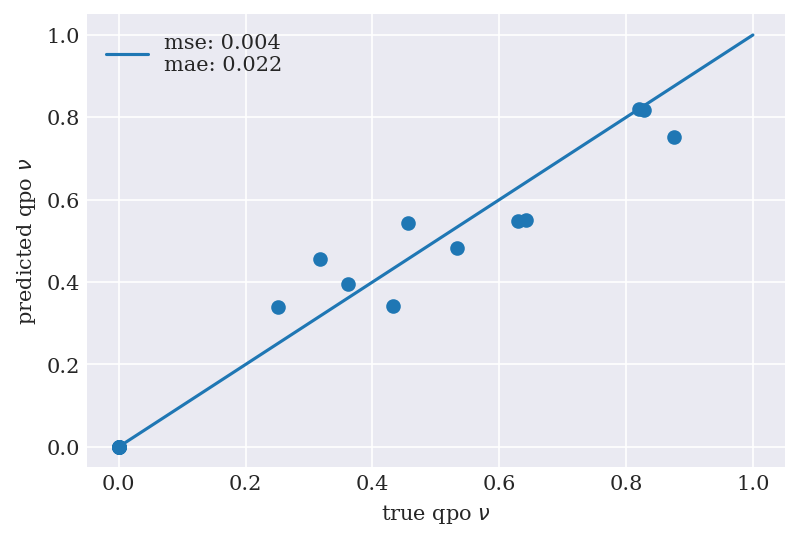

In [441]:
model = SVR(kernel='rbf')

wrapper = RegressorChain(model, order=[0,1,2])

wrapper.fit(results[4],results[6])

x_test_qpo_should_exist, y_test_qpo_should_exist = drop_no_qpo(results[5], results[7], knn_predictions)
chained_predictions = cullBuffers(wrapper.predict(x_test_qpo_should_exist), knn_predictions).flatten()

mse = mean_squared_error(y_test_qpo_should_exist.flatten(), chained_predictions)
mae = median_absolute_error(y_test_qpo_should_exist.flatten(), chained_predictions)

fig, ax = plt.subplots()

line_label = 'mse: '+str(round(mse, 3))+'\n'+'mae: '+str(round(mae, 3))
ax.plot([0,1], [0,1], label=line_label)
ax.scatter(y_test_qpo_should_exist.flatten(), chained_predictions)

ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')
ax.legend()
plt.show()

### RANDOM FOREST

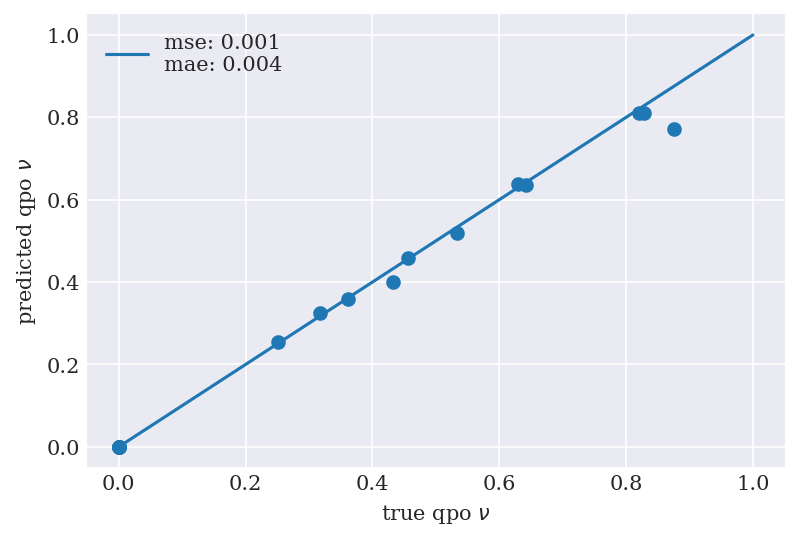

In [442]:
regr = RandomForestRegressor()
regr.fit(results[4],results[6])
rf_predictions = cullBuffers(regr.predict(results[5]), knn_predictions).flatten()

mse = mean_squared_error(results[7].flatten(), rf_predictions)
mae = median_absolute_error(results[7].flatten(), rf_predictions)
fig, ax = plt.subplots()

line_label = 'mse: '+str(round(mse, 3))+'\n'+'mae: '+str(round(mae, 3))
ax.plot([0,1], [0,1], label=line_label)
ax.scatter(results[7].flatten(), rf_predictions)

ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')
ax.legend()
plt.show()

### XGBOOST

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[00:15:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:15:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:15:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


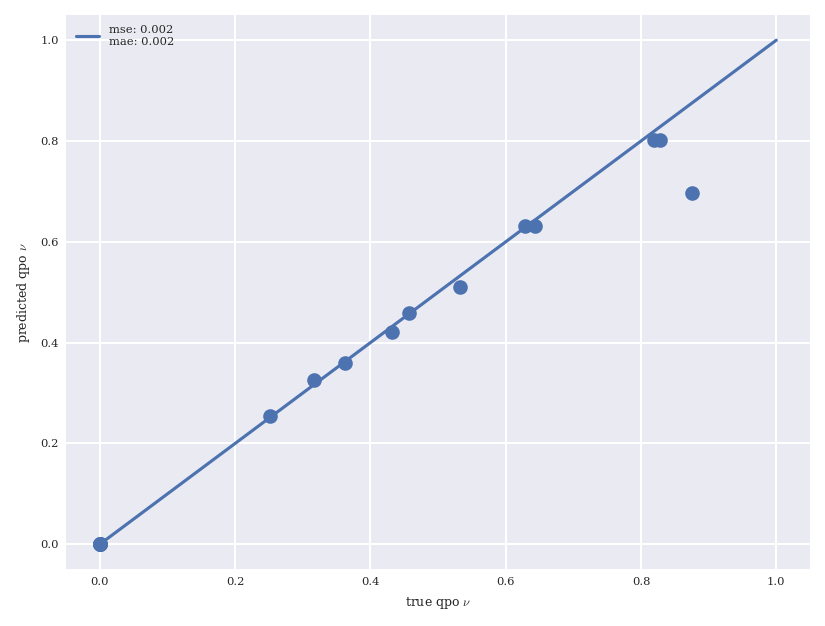

[[0.25134349 0.31697137 0.        ]
 [0.64281334 0.81966524 0.        ]
 [0.87584182 0.         0.        ]
 [0.36190685 0.45640422 0.        ]
 [0.43187854 0.53274577 0.        ]
 [0.62876732 0.82877142 0.        ]]


In [491]:
model = xgboost.XGBRegressor()

xgb_wrapper = RegressorChain(model, order=[0,1,2])

xgb_wrapper.fit(results[4],results[6])

x_test_qpo_should_exist, y_test_qpo_should_exist = drop_no_qpo(results[5], results[7], knn_predictions)
chained_predictions = cullBuffers(xgb_wrapper.predict(x_test_qpo_should_exist), knn_predictions).flatten()

mse = mean_squared_error(y_test_qpo_should_exist.flatten(), chained_predictions)
mae = median_absolute_error(y_test_qpo_should_exist.flatten(), chained_predictions)

fig, ax = plt.subplots()

line_label = 'mse: '+str(round(mse, 3))+'\n'+'mae: '+str(round(mae, 3))
ax.plot([0,1], [0,1], label=line_label)
ax.scatter(y_test_qpo_should_exist.flatten(), chained_predictions)

ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')
ax.legend()
plt.show()

print(y_test_qpo_should_exist)

## sanity checks 🥰

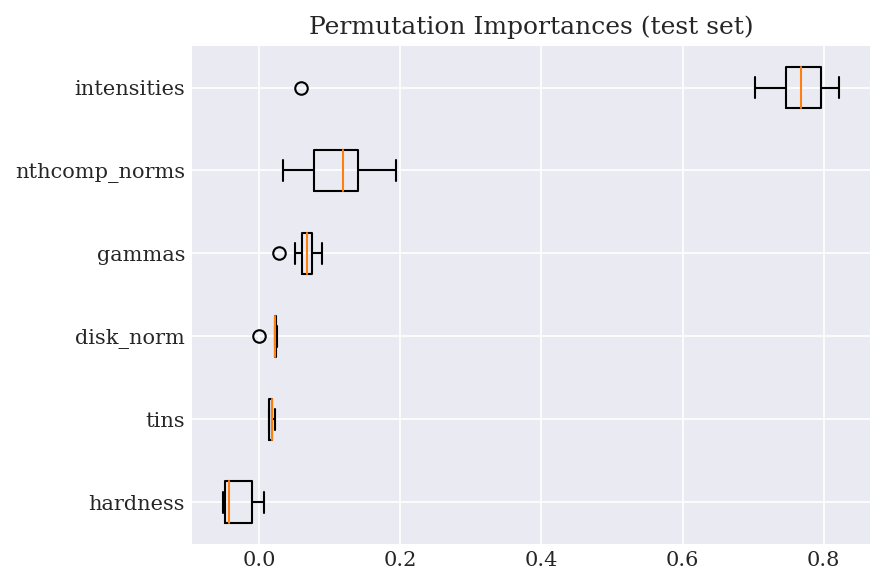

In [450]:
from sklearn.inspection import permutation_importance

permutation_result = permutation_importance(
    regr, results[5], results[7], n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = permutation_result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    permutation_result.importances[sorted_idx].T, vert=False, 
    labels=['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities'])

ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [451]:
cols_to_check = ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
cols_to_check += ['first_par1s','first_par2s','first_norms','second_par1s', 'second_par2s']	
cols_to_check += ['second_norms','third_par1s','third_par2s','third_norms', 'count_rates']


for col_name in cols_to_check: 
    print(np.min(data_df[col_name]), np.max(data_df[col_name]))

0.0 1.0
0.0 1.0
0.0 1.0000000000000002
0.0 1.0
0.0 1.0
0.0 1.0
0.0 0.9999999999999999
0.0 1.0
0.0 0.9999999999999999
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


[(0.012759491921377823, 0.12481750000000003, 0.005612972930865257, 1.0, 0.0015204229595248658, 0.003210470213375064, 0.0), (0.6776861089309324, 0.0, 0.8496687677072631, 0.41197586206896547, 0.2549701716866074, 0.4017921680896854, 2.0), (0.6338168029801704, 0.99999875, 0.0, 0.718096551724138, 2.377982003694604e-05, 0.6904399093248296, 2.0), (0.6517162955521136, 0.0, 0.7858967185424651, 0.4383310344827585, 0.3033297799789447, 0.4355372858025043, 2.0), (0.5106065763839607, 0.0, 0.0, 0.5889655172413795, 0.814600975958578, 0.7062730190293762, 0.0), (0.19572777124401314, 0.9717100000000001, 8.125149693337207e-05, 0.14664482758620695, 1.6079731975554683e-19, 0.1116128942025601, 0.0), (0.5090587296161387, 1.250000000008189e-06, 0.022875723436007085, 0.590848275862069, 0.788665903026531, 0.6798170134440298, 0.0), (0.5762749409559356, 0.0, 0.26621487781454467, 0.5231689655172416, 0.9196323933497097, 0.9781770985084269, 2.0), (0.5127785847518774, 0.11782999999999999, 0.0, 0.6082310344827586, 0.89

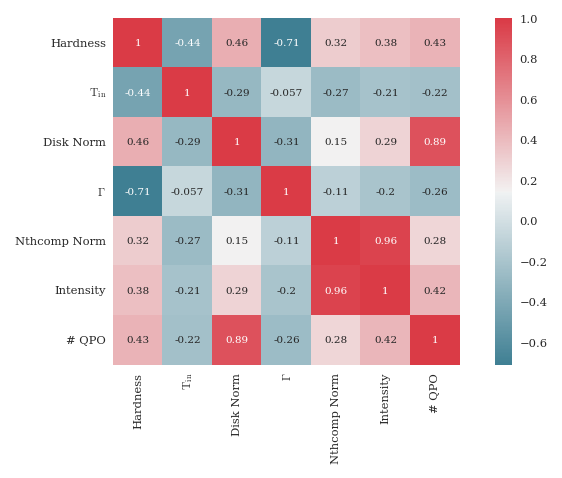

In [489]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib as mpl
import shap

sns.set(font_scale=0.5)
plt.style.use('seaborn-darkgrid')
plt.rcParams['font.family']='serif'
plt.rcParams['figure.dpi']=150
plt.rcParams['mathtext.fontset'] = 'cm'


norm_cols = ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']

hardness, tins, disk_norm, gammas, nthcomp_norms, intensities = (np.array(data_df[arr_name]) for arr_name in norm_cols)
num_qpos = np.array(data_df['num_qpos'])

zipped = list(zip(hardness, tins, disk_norm, gammas, nthcomp_norms, intensities, num_qpos))
print(zipped)
corr_df = pd.DataFrame(zipped, columns=norm_cols+['num_qpos'])

# Correlation matrix

fig, ax = plt.subplots(figsize=(6, 3))
corr = corr_df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

tick_labels = ['Hardness', r'$\mathrm{T}_{\mathrm{in}}$', 'Disk Norm', r'$\Gamma$', 'Nthcomp Norm', 'Intensity', '# QPO']

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True, annot_kws={'fontsize':'small'}, yticklabels=tick_labels,\
            xticklabels=tick_labels)

#sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(220, 10, as_cmap=True),
#            square=True, ax=ax)

plt.show()

In [475]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)